# **MNIST: Sklearn and Keras** 
**Comparing the performance of ML and DL classification models on**  
**the Digit Recognizer (MNIST) competition**  


*from Kaggle:*   
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision.  
In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

**My first kernel for the MNIST Digit Recognizer Competition**  

The kernel includes an **EDA part** on the distribution of labels and some sample images for each digit.  
We explore how the images of handwritten digits are stored as 784 values (pixels).  
We transform these 784 pixels back to images of 28 x 28 (width x heigth) and have a look at possible difficulties in identifying and distinguishing certain digits.  
The part on **prediction modelling** starts with **classifiers from sklearn**:  
Perceptron, Logistic Regression, Random Forest, SVM, Multi Layer Perceptron  
and then continues to **Neural Networks with Keras**:   
Dense (1,2 and 3 layers) and CNN (Conv2D, MaxPooling, Dropout)

**Outline of the kernel:**

**Part 0: Imports, functions**

[some useful functions](#some-useful-functions)


**Part 1: Exploring the Data**

[Distribution of labels](#Distribution-of-labels)  
[first 10 samples for each digit](#first-10-image-samples-for-each-digit)  
[Conclusions on EDA](#Conclusions-on-EDA) 


**Part 2: Sklearn Classifiers** 

[Perceptron](#Perceptron)  
[Logistic Regression](#Logistic-Regression)  
[KNN](#KNN)  
[Random Forest Classifier](#Random-Forest-Classifier)  
[Support Vector Machine Classifier](#Support-Vector-Machine-Classifier)  
[Multi Layer Perceptron](#Multi-Layer-Perceptron)


**Part 3: NN and CNN Classifiers with Keras**

3.1 Fully-Connected Neural Networks  
[Keras: dense, 1 hidden layer](#Keras:-1-hidden-layer)  
[Keras: dense, 2 hidden layers](#Keras:-2-hidden-layers)  
[Keras: dense, 3 hidden layers](#Keras:-3-hidden-layers)  
3.2 Convolutional Neural Networks, CNN  
[features : reshaping 1d vector to 2d images](#features-:-reshaping-1d-vector-to-2d-images)  
[Keras: CNN, model 1](#Keras:-CNN-model-1)  
[Keras: CNN, model 2](#Keras:-CNN-model-2)

**Part 4: Predictions for test data**  
[Fitting on all training data](#Fitting-on-all-training-data)  

**Part 5: Comparing classifier performance**  
[Validation scores](#Validation-scores)  
[Test scores](#Test-scores)  


**Part 6: Different optimizers**  
adadelta  
rmsprop  
adam  

**Part 7: Investigating false predictions**


# Part 0: Imports, Functions

In [1]:
import numpy as np 
import pandas as pd 

import random as rn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# plotly library
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

import itertools

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
#from keras.layers import AvgPool2D, BatchNormalization, Reshape
from keras.optimizers import Adadelta, RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

import os
print(os.listdir("MNIST"))


['mnist_train_pt1.csv', 'mnist_train_pt2.csv', 'mnist_test.csv']


**some global variables**

In [2]:
img_rows, img_cols = 28, 28

np.random.seed(5)
#rn.seed(5)
#tf.set_random_seed(5)

### **some useful functions**

### get_best_score for GridSearchCV

In [3]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

### print Classification Report and Accuracy

In [4]:
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

### plot_confusion_matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### plot_history_loss_and_acc

In [6]:
def plot_history_loss_and_acc(history_keras_nn):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_keras_nn.history['loss'])
    axs[0].plot(history_keras_nn.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')

    axs[1].plot(history_keras_nn.history['acc'])
    axs[1].plot(history_keras_nn.history['val_acc'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

### **Reading the data**

In [7]:
train = pd.read_csv("MNIST/mnist_train_pt1.csv").append(pd.read_csv("MNIST/mnist_train_pt2.csv"), ignore_index=True)
test = pd.read_csv("MNIST/mnist_test.csv")

In [8]:
y = train["label"]
X = train.drop(["label"],axis = 1)
X_test = test

### Normalization

In [9]:
X = X/255.0
X_test = X_test/255.0

### setting train and validation data

In [10]:
# for best performance, especially of the NN classfiers,
# set mode = "commit"
mode = "edit"
mode = "commit"
#

if mode == "edit" :
    nr_samples = 1200

if mode == "commit" :    
    nr_samples = 30000

y_train=y[:nr_samples]
X_train=X[:nr_samples]
start_ix_val = nr_samples 
end_ix_val = nr_samples + int(nr_samples/3)
y_val=y[start_ix_val:end_ix_val]
X_val=X[start_ix_val:end_ix_val]
    
print("nr_samples train data:", nr_samples)
print("start_ix_val:", start_ix_val)
print("end_ix_val:", end_ix_val)

nr_samples train data: 30000
start_ix_val: 30000
end_ix_val: 40000


# Part 1 : Exploring the Data

In [11]:
print("X:")
print(X.info())
print("*"*50)
print("X_test:")
print(X_test.info())
print("*"*50)
print("y:")
print(y.shape)

X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 784 entries, 1x1 to 28x28
dtypes: float64(784)
memory usage: 358.9 MB
None
**************************************************
X_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: float64(785)
memory usage: 59.9 MB
None
**************************************************
y:
(60000,)


In [12]:
X.iloc[0:5,:]

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y.iloc[0:5]

0    5
1    0
2    4
3    1
4    9
Name: label, dtype: int64

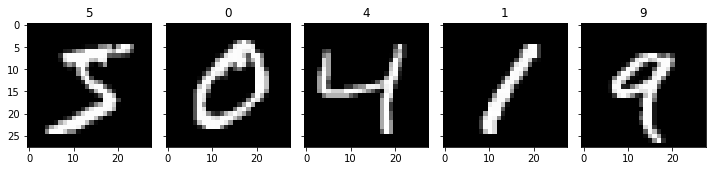

In [14]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,6))
axs = axs.flatten()
for i in range(0,5):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[i].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[i].set_title(y[i])
plt.tight_layout()    

### Distribution of labels 
**(in train set)**

In [15]:
y.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

/usr/local/Caskroom/mambaforge/base/envs/ads/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



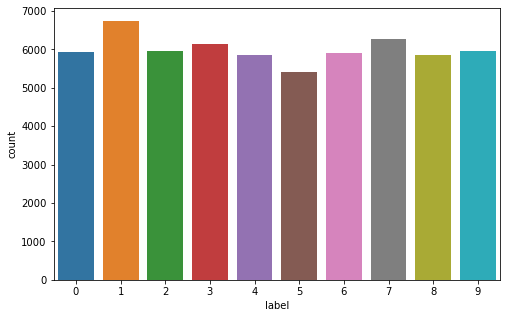

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.countplot(y)

### Check some images

**get indexes of first 10 occurences for each number**

In [17]:
li_idxs = []
for i in range(10):
    for nr in range(10):
        ix = y[y==nr].index[i]
        li_idxs.append(ix) 

### first 10 image samples for each digit

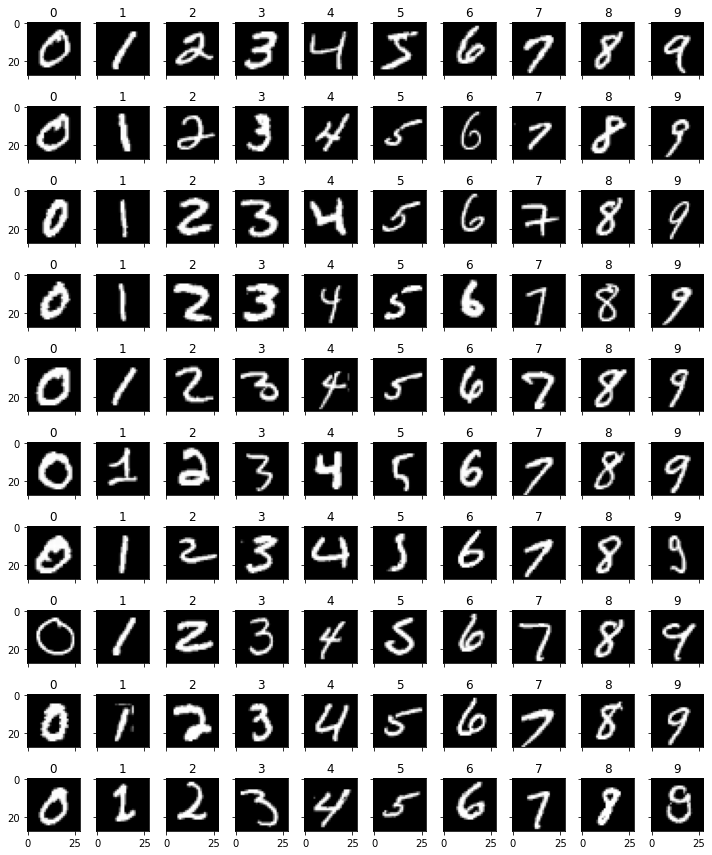

In [18]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()
for n, i in enumerate(li_idxs):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(y[i])
plt.tight_layout()    

### **Conclusions on EDA**

1. **We can see that there is a lot of variety in the look of the numbers**  
2. **The digits are obviously written by many different people**
3. **And it seems that there might be difficulties identifying some of the digits correctly also for humans:**




* The 6s in row 0 1 and 6 look close to a 4  
* The 5 in row 1 looks close to a 6 and the 5 in row 8 looks close to a 8  
* The 4 in row 4 is wriiten differently as the other 4s and the 4 in row 7 almost looks like a 7  
* The 8 in row 8 is wriiten differently as the other 8s  

# Part 2 : Sklearn Classifiers

### Perceptron

In [19]:
from sklearn.linear_model import Perceptron
clf_Perceptron = Perceptron(random_state=0)
param_grid = { 'penalty': ['l1','l2'], 'tol': [0.05, 0.1] }
GridCV_Perceptron = GridSearchCV(clf_Perceptron, param_grid, verbose=1, cv=5)
GridCV_Perceptron.fit(X_train,y_train)
score_grid_Perceptron = get_best_score(GridCV_Perceptron)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.8480333333333334
{'penalty': 'l1', 'tol': 0.1}
Perceptron(penalty='l1', tol=0.1)


In [20]:
pred_val_perc = GridCV_Perceptron.predict(X_val)

In [21]:
acc_perc = print_validation_report(y_val, pred_val_perc)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       963
           1       0.91      0.94      0.92      1140
           2       0.64      0.94      0.76       995
           3       0.85      0.85      0.85      1008
           4       0.84      0.89      0.86       983
           5       0.83      0.78      0.81       895
           6       0.96      0.86      0.91      1000
           7       0.86      0.89      0.87      1018
           8       0.84      0.77      0.80       985
           9       0.95      0.61      0.74      1013

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

Accuracy : 0.8486


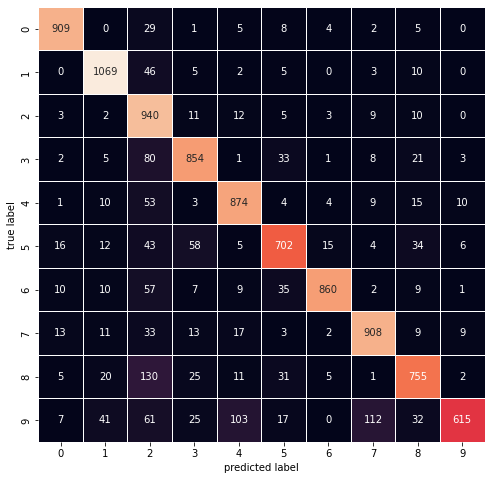

In [22]:
plot_confusion_matrix(y_val, pred_val_perc)

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(random_state=0)
param_grid = {'C': [0.014,0.012], 'multi_class': ['multinomial'],  
              'penalty': ['l1'],'solver': ['saga'], 'tol': [0.1] }
GridCV_LR = GridSearchCV(clf_LR, param_grid, verbose=1, cv=5)
GridCV_LR.fit(X_train,y_train)
score_grid_LR = get_best_score(GridCV_LR)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.8667333333333334
{'C': 0.014, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1}
LogisticRegression(C=0.014, multi_class='multinomial', penalty='l1',
                   random_state=0, solver='saga', tol=0.1)


In [24]:
pred_val_lr = GridCV_LR.predict(X_val)
acc_lr = print_validation_report(y_val, pred_val_lr)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       963
           1       0.88      0.95      0.91      1140
           2       0.91      0.85      0.88       995
           3       0.87      0.84      0.85      1008
           4       0.86      0.89      0.87       983
           5       0.82      0.78      0.80       895
           6       0.90      0.89      0.90      1000
           7       0.89      0.89      0.89      1018
           8       0.84      0.81      0.82       985
           9       0.82      0.85      0.83      1013

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy : 0.8723


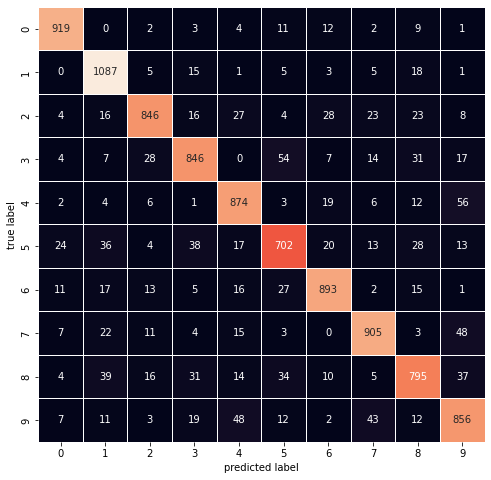

In [25]:
plot_confusion_matrix(y_val, pred_val_lr)

### KNN

Using GridSearchCV with KNN takes very long for this dataset.  
Therefore I fit the data with one parameter: neighbors = 10  
The resulting accuracy is already quite good.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [27]:
pred_val_knn = clf_knn.predict(X_val)
acc_knn = print_validation_report(y_val, pred_val_knn)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       963
           1       0.94      0.99      0.96      1140
           2       0.98      0.95      0.96       995
           3       0.95      0.96      0.95      1008
           4       0.97      0.96      0.96       983
           5       0.94      0.94      0.94       895
           6       0.97      0.98      0.98      1000
           7       0.95      0.96      0.95      1018
           8       0.99      0.90      0.94       985
           9       0.94      0.96      0.95      1013

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy : 0.9585


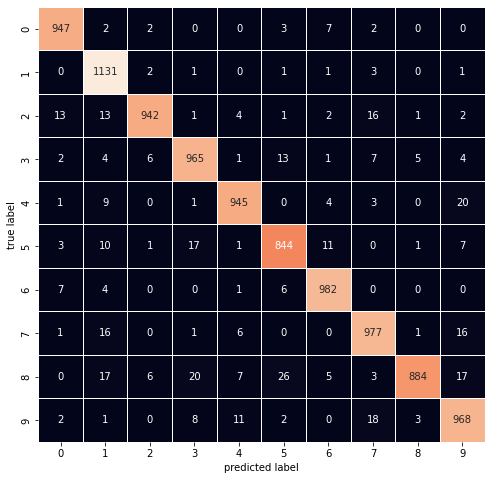

In [28]:
plot_confusion_matrix(y_val, pred_val_knn)

### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(random_state=0)
param_grid = {'max_depth': [15], 'max_features': [100],  
              'min_samples_split': [5],'n_estimators' : [50] }
GridCV_RF = GridSearchCV(clf_RF, param_grid, verbose=1, cv=5)
GridCV_RF.fit(X_train,y_train)
score_grid_RF = get_best_score(GridCV_RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9526333333333333
{'max_depth': 15, 'max_features': 100, 'min_samples_split': 5, 'n_estimators': 50}
RandomForestClassifier(max_depth=15, max_features=100, min_samples_split=5,
                       n_estimators=50, random_state=0)


'RandomForestClassifier' object has no attribute 'loss_curve_'

In [30]:
pred_val_rf = GridCV_RF.predict(X_val)

In [31]:
acc_rf = print_validation_report(y_val, pred_val_rf)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       963
           1       0.98      0.98      0.98      1140
           2       0.95      0.96      0.95       995
           3       0.95      0.93      0.94      1008
           4       0.96      0.96      0.96       983
           5       0.95      0.94      0.94       895
           6       0.97      0.97      0.97      1000
           7       0.96      0.95      0.96      1018
           8       0.94      0.94      0.94       985
           9       0.93      0.94      0.94      1013

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy : 0.9554


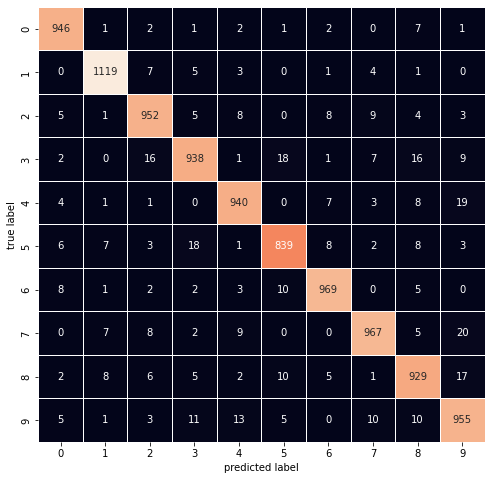

In [32]:
plot_confusion_matrix(y_val, pred_val_rf)

### Support Vector Machine Classifier

Like for KNN, GridSearchCV for SVM takes very long, so I only fit one good set of parameters here.

In [33]:
from sklearn.svm import SVC
clf_svm = SVC(C=5, gamma=0.05, kernel='rbf', random_state=0)
clf_svm.fit(X_train,y_train)

SVC(C=5, gamma=0.05, random_state=0)

In [34]:
pred_val_svm = clf_svm.predict(X_val)
acc_svm = print_validation_report(y_val, pred_val_svm)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       963
           1       0.99      0.99      0.99      1140
           2       0.97      0.98      0.97       995
           3       0.98      0.97      0.97      1008
           4       0.98      0.98      0.98       983
           5       0.98      0.97      0.97       895
           6       0.99      0.99      0.99      1000
           7       0.98      0.97      0.98      1018
           8       0.96      0.98      0.97       985
           9       0.97      0.97      0.97      1013

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy : 0.9781


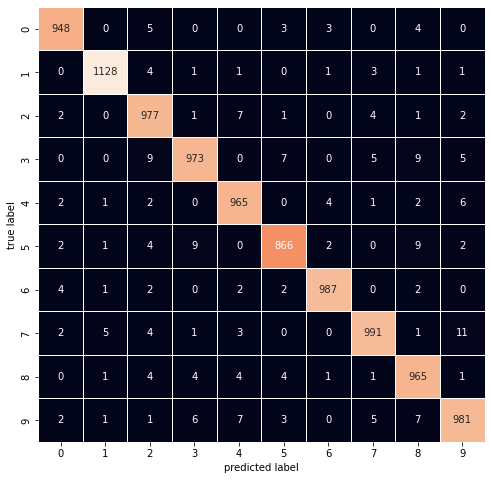

In [35]:
plot_confusion_matrix(y_val, pred_val_svm)

### Multi Layer Perceptron

In [36]:
batchsize = int(nr_samples/15) 

In [37]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(activation = "logistic", hidden_layer_sizes=(200,), random_state=0)
param_grid = { 'batch_size' : [batchsize] , 'max_iter': [600], 'alpha': [1e-4], 
               'solver': ['sgd'], 'learning_rate_init': [0.05,0.06],'tol': [1e-4] }
    
GridCV_MLP = GridSearchCV(clf_mlp, param_grid, verbose=1, cv=3)
GridCV_MLP.fit(X_train,y_train)
score_grid_MLP = get_best_score(GridCV_MLP)   

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0.9598666666666666
{'alpha': 0.0001, 'batch_size': 2000, 'learning_rate_init': 0.06, 'max_iter': 600, 'solver': 'sgd', 'tol': 0.0001}
MLPClassifier(activation='logistic', batch_size=2000, hidden_layer_sizes=(200,),
              learning_rate_init=0.06, max_iter=600, random_state=0,
              solver='sgd')


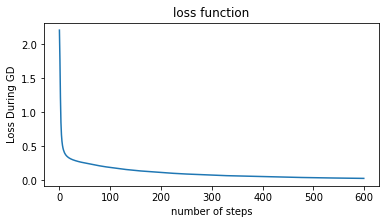

In [38]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(GridCV_MLP.best_estimator_.loss_curve_)

plt.xlabel("number of steps") 
plt.ylabel("Loss During GD")
plt.title("loss function")
plt.show()

In [39]:
pred_val_mlp = GridCV_MLP.predict(X_val)

In [40]:
acc_mlp = print_validation_report(y_val, pred_val_mlp)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       963
           1       0.98      0.99      0.98      1140
           2       0.97      0.97      0.97       995
           3       0.96      0.96      0.96      1008
           4       0.96      0.97      0.96       983
           5       0.97      0.94      0.96       895
           6       0.97      0.98      0.97      1000
           7       0.97      0.97      0.97      1018
           8       0.96      0.96      0.96       985
           9       0.95      0.96      0.95      1013

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy : 0.9669


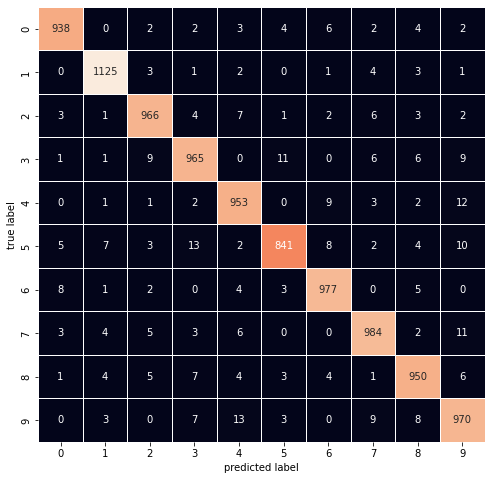

In [41]:
plot_confusion_matrix(y_val, pred_val_mlp)

# Part 3: NN Classifiers with Keras

In [42]:
y_train = to_categorical(y_train, 10)
y_val_10 = to_categorical(y_val, 10)

## 3.1 Fully-Connected Neural Networks  
dense layers : every node is connected to every other node in the next layer

### 3.1.1 Keras: only input and output layer

In [43]:
def dense_model_0():
    model = Sequential()
    model.add(Dense(10, input_dim=784, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [44]:
model_dense_0 = dense_model_0()
model_dense_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2021-09-01 10:38:19.506413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
model_dense_0.fit(X_train, y_train, epochs=50, batch_size=batchsize)

2021-09-01 10:38:19.780171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
15/15 [==============================] - 0s 7ms/step - loss: 2.2320 - accuracy: 0.1855
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 1.6337 - accuracy: 0.6121
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 1.2507 - accuracy: 0.7544
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 1.0214 - accuracy: 0.7950
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 0.8692 - accuracy: 0.8208
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.7699 - accuracy: 0.8381
Epoch 7/50
15/15 [==============================] - 0s 8ms/step - loss: 0.7063 - accuracy: 0.8451
Epoch 8/50
15/15 [==============================] - 0s 8ms/step - loss: 0.6471 - accuracy: 0.8570
Epoch 9/50
15/15 [==============================] - 0s 7ms/step - loss: 0.6040 - accuracy: 0.8649
Epoch 10/50
15/15 [==============================] - 0s 8ms/step - loss: 0.5752 - accuracy: 0.8674
Epoch 11/50
15/15 [

In [46]:
pred_val_dense0 = model_dense_0.predict_classes(X_val)

/usr/local/Caskroom/mambaforge/base/envs/ads/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [47]:
acc_fc0 = print_validation_report(y_val, pred_val_dense0)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       963
           1       0.94      0.96      0.95      1140
           2       0.92      0.88      0.90       995
           3       0.89      0.88      0.89      1008
           4       0.91      0.92      0.91       983
           5       0.86      0.83      0.84       895
           6       0.94      0.94      0.94      1000
           7       0.92      0.90      0.91      1018
           8       0.85      0.88      0.87       985
           9       0.86      0.89      0.88      1013

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000

Accuracy : 0.9058


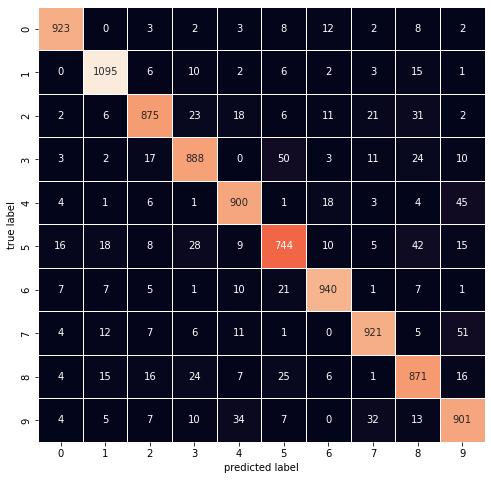

In [48]:
plot_confusion_matrix(y_val, pred_val_dense0)

### Keras: 1 hidden layer

In [49]:
def dense_model_1():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
model_dense_1 = dense_model_1()
model_dense_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_dense_1 = model_dense_1.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

Epoch 1/50
15/15 [==============================] - 2s 102ms/step - loss: 1.9951 - accuracy: 0.3494 - val_loss: 1.0698 - val_accuracy: 0.7631
Epoch 2/50
15/15 [==============================] - 0s 18ms/step - loss: 0.8793 - accuracy: 0.8035 - val_loss: 0.5991 - val_accuracy: 0.8468
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 0.5311 - accuracy: 0.8600 - val_loss: 0.4583 - val_accuracy: 0.8741
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4106 - accuracy: 0.8874 - val_loss: 0.3959 - val_accuracy: 0.8903
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.3644 - accuracy: 0.8997 - val_loss: 0.3595 - val_accuracy: 0.9017
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 0.3255 - accuracy: 0.9121 - val_loss: 0.3341 - val_accuracy: 0.9065
Epoch 7/50
15/15 [==============================] - 0s 19ms/step - loss: 0.2986 - accuracy: 0.9186 - val_loss: 0.3158 - val_accuracy: 0.9094
Epoch 8/50
1

KeyError: 'acc'

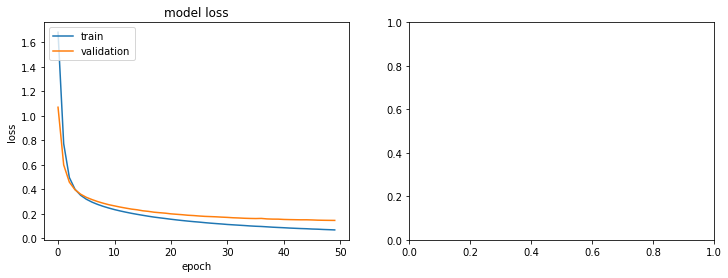

In [52]:
plot_history_loss_and_acc(history_dense_1)

In [ ]:
pred_val_dense1 = model_dense_1.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense1)
print(classification_report(y_val, pred_val_dense1))
acc_fc1 = accuracy_score(y_val, pred_val_dense1)
print(acc_fc1)

### Keras: 2 hidden layers

In [ ]:
def dense_model_2():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model_dense_2 = dense_model_2()
model_dense_2.summary()

In [ ]:
history_dense_2 = model_dense_2.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

In [ ]:
plot_history_loss_and_acc(history_dense_2)

In [ ]:
pred_val_dense2 = model_dense_2.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense2)
print(classification_report(y_val, pred_val_dense2))
acc_fc2 = accuracy_score(y_val, pred_val_dense2)
print(acc_fc2)

### Keras: 3 hidden layers

In [ ]:
def dense_model_3():
    
    model = Sequential()  
    model.add(Dense(100, activation='relu', input_dim=784))
    model.add(Dense(200, activation='relu')) 
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(10, activation='softmax'))
         
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #model.compile(optimizer=RMSprop(lr=0.001),
    #         loss='categorical_crossentropy',
    #         metrics=['accuracy'])
    
    return model

In [ ]:
model_dense_3 = dense_model_3()
model_dense_3.summary()

In [ ]:
history_dense_3 = model_dense_3.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

In [ ]:
plot_history_loss_and_acc(history_dense_3)

In [ ]:
pred_val_dense3 = model_dense_3.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense3)
print(classification_report(y_val, pred_val_dense3))
acc_fc3 = accuracy_score(y_val, pred_val_dense3)
print(acc_fc3)

## 3.2 Keras : Convolutional Neural Networks, CNN

Convnets:  
[Udacity](https://www.youtube.com/watch?v=jajksuQW4mc) 

### **features : reshaping 1d vector to 2d images**

(784) --> (28,28,1)

In [ ]:
X_train.shape

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.values.reshape(X_val.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

## Keras: CNN model 1
Conv2D (32, (3, 3))  
Conv2D (64, (3, 3))  
Pooling2D (2,2)  
Dropout (0.25)
Flatten  
Dense(128, relu)  
Dropout (0.5)  
Dense(10, softmax)

In [ ]:
batchsize = 128
epochs = 12

In [ ]:
activation = 'relu'
adadelta = Adadelta()
loss = categorical_crossentropy

In [ ]:
def cnn_model_1(activation):
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape)) 
    
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())

    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=loss, optimizer=adadelta, metrics=['accuracy'])

    return model

In [ ]:
model_cnn_1 = cnn_model_1(activation)
model_cnn_1.summary()

In [ ]:
#model_cnn_1.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, verbose=1)
history_cnn_1 = model_cnn_1.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                   epochs=epochs, batch_size=batchsize, verbose=1)

In [ ]:
plot_history_loss_and_acc(history_cnn_1)

In [ ]:
pred_val_cnn1 = model_cnn_1.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_cnn1)
print(classification_report(y_val, pred_val_cnn1))
acc_cnn1 = accuracy_score(y_val, pred_val_cnn1)
print(acc_cnn1)


### Keras: CNN model 2  
Conv2D (32, (3, 3))  
Pooling2D (2,2)  
Conv2D (32, (3, 3))  
Pooling2D (2,2)  
Flatten  
Dense(256, relu)  
Dense(10, softmax)  

In [ ]:
batch_size=90
epochs=30


In [ ]:
def cnn_model_2(optimizer,loss):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'Same', activation="relu", input_shape=input_shape ))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation=activation))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy']) 

    return model

In [ ]:
model_cnn_2 = cnn_model_2(adadelta, categorical_crossentropy)
model_cnn_2.summary()

In [ ]:
#model_cnn_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
history_cnn_2 = model_cnn_2.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                epochs=epochs, batch_size=batchsize, verbose=1)

In [ ]:
plot_history_loss_and_acc(history_cnn_2)

In [ ]:
pred_val_cnn2 = model_cnn_2.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_cnn2)
print(classification_report(y_val, pred_val_cnn2))
acc_cnn2 = accuracy_score(y_val, pred_val_cnn2)
print(acc_cnn2)

# Part 4: Predictions for test data

In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
if mode == "edit" :
    X = X[:nr_samples//2]
    y = y[:nr_samples//2]
    X_test = X_test[:nr_samples//2]
    sample_submission = sample_submission[:nr_samples//2]

In [ ]:
print(X.shape)
print(y.shape)
print(X_test.shape)

## Fitting on all training data

**For the GridSearchCV studies on finding the best model parameters we fit the classifiers using cross validation.**  
**This reduces the number of training examples because a portion of the data is used for validation.**  
**We now fit the classifiers on the complete training set (42000 samples).**  
**Then we use this new fit to make predictions for the test dataset (28000 samples).**

**Perceptron**

In [ ]:
print(GridCV_Perceptron.best_params_)
GridCV_Perceptron.best_estimator_.fit(X,y)

In [ ]:
pred_test_perc = GridCV_Perceptron.best_estimator_.predict(X_test)
result_perc = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_perc})
result_perc.to_csv("subm_perc.csv",index=False)

**Logistic Regression**

In [ ]:
print(GridCV_LR.best_params_)
GridCV_LR.best_estimator_.fit(X,y)

In [ ]:
pred_test_lr = GridCV_LR.best_estimator_.predict(X_test)
result_lr = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_lr})
result_lr.to_csv("subm_lr.csv",index=False)

**KNN**

In [ ]:
clf_knn.fit(X,y)

In [ ]:
pred_test_knn = clf_knn.predict(X_test)
result_knn = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_knn})
result_knn.to_csv("subm_knn.csv",index=False)

**Random Forest**

In [ ]:
print(GridCV_RF.best_params_)
GridCV_RF.best_estimator_.fit(X,y)

In [ ]:
pred_test_rf = GridCV_RF.best_estimator_.predict(X_test)
result_rf = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_rf})
result_rf.to_csv("subm_rf.csv",index=False)

**SVM**

In [ ]:
clf_svm.fit(X,y)

In [ ]:
pred_test_svm = clf_svm.predict(X_test)
result_svm = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_svm})
result_svm.to_csv("subm_svm.csv",index=False)

**MLP**

In [ ]:
print(GridCV_MLP.best_params_)
GridCV_MLP.best_estimator_.fit(X,y)

In [ ]:
pred_test_mlp = GridCV_MLP.best_estimator_.predict(X_test)
result_mlp = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_mlp})
result_mlp.to_csv("subm_mlp.csv",index=False)

In [ ]:
y = to_categorical(y, 10)

**dense_1**

In [ ]:
model_dense_1.fit(X,y)
pred_test_fc1 = model_dense_1.predict_classes(X_test)
result_fc1 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_fc1})
result_fc1.to_csv("dense_1.csv",index=False)

**dense_2**

In [ ]:
model_dense_2.fit(X,y)
pred_test_fc2 = model_dense_2.predict_classes(X_test)
result_fc2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_fc2})
result_fc2.to_csv("dense_2.csv",index=False)

**dense_3**

In [ ]:
model_dense_3.fit(X,y)
pred_test_fc3 = model_dense_3.predict_classes(X_test)
result_fc3 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_fc3})
result_fc3.to_csv("dense_3.csv",index=False)

**reshape for CNN**

In [ ]:
X = X.values.reshape(X.shape[0], img_rows, img_cols, 1)
X_test = X_test.values.reshape(X_test.shape[0], img_rows, img_cols, 1)
#y = to_categorical(y, 10)

**CNN 1**

In [ ]:
batchsize = 128
epochs = 12
model_cnn_1 = cnn_model_1('relu')
model_cnn_1.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)

In [ ]:
pred_test_cnn_1 = model_cnn_1.predict(X_test)
pred_test_cnn_1 = np.argmax(pred_test_cnn_1,axis=1)
result_cnn_1 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_1})
result_cnn_1.to_csv("subm_cnn_1.csv",index=False)

**CNN 2**

In [ ]:
batch_size=90
epochs=30
model_cnn_2 = cnn_model_2(adadelta, categorical_crossentropy)
model_cnn_2.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)

In [ ]:
pred_test_cnn_2 = model_cnn_2.predict(X_test)
pred_test_cnn_2 = np.argmax(pred_test_cnn_2,axis=1)
result_cnn_2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_2})
result_cnn_2.to_csv("subm_cnn_2_adadelta.csv",index=False)

Correlation of prediction results

In [ ]:
predictions = {'PERC': pred_test_perc, 'LR': pred_test_lr, 'KNN': pred_test_knn, 
               'RF': pred_test_rf, 'SVM': pred_test_svm, 'MLP': pred_test_mlp, 
               'DENSE1': pred_test_fc1, 'DENSE2': pred_test_fc2, 'DENSE3': pred_test_fc3, 
               'CNN1': pred_test_cnn_1, 'CNN2': pred_test_cnn_2}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

# Part 5: Comparing classifier performance

In [ ]:
list_classifiers = ['PERC','LR','KNN','RF','SVM',
                    'MLP','DENSE1','DENSE2','DENSE3',
                    'CNN1','CNN2']

## Validation scores

from validation data

In [ ]:
val_scores = [acc_perc, acc_lr, acc_knn, acc_rf, 
               acc_svm, acc_mlp, acc_fc1, acc_fc2, 
               acc_fc3, acc_cnn1, acc_cnn2]

## Test scores

from submission 

In [ ]:
score_perc  = 0.88057
score_lr    = 0.88700
score_knn   = 0.96557
score_rf    = 0.96028
score_svm   = 0.98100
score_mlp   = 0.96985

score_dns_1  = 0.95971 
score_dns_2  = 0.96228      
score_dns_3  = 0.96128
score_cnn_1  = 0.98928
score_cnn_2  = 0.99028

In [ ]:
test_scores = [score_perc, score_lr, score_knn, score_rf, score_svm, score_mlp,
               score_dns_1, score_dns_2, score_dns_3, score_cnn_1, score_cnn_2]

In [ ]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validation", text = list_classifiers)
trace2 = go.Scatter(x = list_classifiers, y = test_scores,
                   name="Submission", text = list_classifiers)

data = [trace1, trace2]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

## Conclusions on classifier performance

* Best accuracy around 99% is obtained with CNN1 and CNN2.  
* SVC also has very good accuracy with 98%  
* Except for Perceptron and Logistic regression, all classifiers get accuarcy similar to humans (above 95%)  
* Fully connected NNs (dense 1,2,3) show most overfitting (validation score much larger than test score)

# Part 6: Different Optimizers

Adadelta

In [ ]:
model_cnn_2.optimizer

RMSprop

In [ ]:
model_cnn_2_rmsprop = cnn_model_2(RMSprop(), categorical_crossentropy)
model_cnn_2_rmsprop.optimizer

In [ ]:
model_cnn_2.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)
pred_test_cnn_2 = model_cnn_2.predict(X_test)
pred_test_cnn_2 = np.argmax(pred_test_cnn_2,axis=1)
result_cnn_2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_2})
result_cnn_2.to_csv("subm_cnn_2_rmsprop.csv",index=False)

Adam

In [ ]:
model_cnn_2_adam = cnn_model_2(Adam(), categorical_crossentropy)
model_cnn_2_adam.optimizer

In [ ]:
model_cnn_2.fit(X, y, epochs=epochs, batch_size=batchsize, verbose=0)
pred_test_cnn_2 = model_cnn_2.predict(X_test)
pred_test_cnn_2 = np.argmax(pred_test_cnn_2,axis=1)
result_cnn_2 = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_cnn_2})
result_cnn_2.to_csv("subm_cnn_2_adam.csv",index=False)

# Part 7: Investigating false predictions

In [ ]:
arr_y_val = y_val.values
false_cnn2 = pred_val_cnn2 != arr_y_val

In [ ]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()
for i, n  in enumerate(false_cnn2[:25]):
    im = X_val[false_cnn2][i,:,:,0]
    axs[i].imshow(im, cmap=plt.get_cmap('gray'))
    title = ("predicted: " + str(pred_val_cnn2[false_cnn2][i]) + 
            "\n" + "true: " + str(arr_y_val[false_cnn2][i]) )
    axs[i].set_title(title)
plt.tight_layout()    